In [29]:
%matplotlib inline
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2020-05-17 16:27:42,149: Credentials are already in use. The existing account in the session will be replaced.


Finding Maxima of an Oracle function using a Quantum Circuit
============================================================

Given a binary function $f:[0,1]^n\to[0,1]$, we wish to find a point $x_m\in[0,1]^n$ such that $f(x_m) = 1$. This algorithm does not focus on efficency and is meant to be taken as an  introductory example of how a quantum circuit works.

The algorithm finds the maxima of a given oracle function by evaluating the entire graph of the function through the use of hadamard gates and reducing the probability of the wrong answers. In order to implement the oracle into the circuit we use the following operator $U$:

$$U\left|y\right\rangle\left|x\right\rangle = \left|1\oplus f(x)\right\rangle\left|x\right\rangle$$.

The whole state uses $n+2$ bits, composed by the $n$ bits of the domain, $y$ for the range and a control bit $c$. Generically, I'll denote a state using the following notation:

$$\left|cyx_0...x_{n-1}\right\rangle = \left|c\right\rangle\left|y\right\rangle\left|x\right\rangle$$.

All bits will start off at zero.

Initially, the domain qubits $\left|x_n\right\rangle$ go through a hadamard gate so that all possible states are available.

$$H\otimes...\otimes H\left|0\right\rangle\left|0\right\rangle\left|0\right\rangle = \frac{1}{2^{\frac{n}{2}}}\sum_{k=0}^{2^n-1}\left|0\right\rangle\left|0\right\rangle\left|k\right\rangle$$.

When the state goes through the gate $U$, we get the graph of $f$:

$$U\frac{1}{2^{\frac{n}{2}}}\sum_{k=0}^{2^n-1}\left|0\right\rangle\left|0\right\rangle\left|k\right\rangle = \frac{1}{2^{\frac{n}{2}}}\sum_{k=0}^{2^n-1}\left|0\right\rangle\left|f(k)\right\rangle\left|k\right\rangle$$.

Qubits which correspond to the maxima of $f$ are somewhere within this state. We can highlight their probabilities by 'diluting' the incorrect states with a Hadamard gate: Any qubits whose $y$ isn't 1 will be split into two so that their individual probabilities are reduced. This will be done with an X gate on $\left|y\right\rangle$ controlled Hadamard gate taking $\left|y\right\rangle$ as control and $\left|c\right\rangle$ as target and then another X gate on $\left|y\right\rangle$ to keep its value unchanged. The job of the $\left|c\right\rangle$ bit is to allow for this splitting to occur without mixing the states so that their probabilites aren't nulified, which could increase the probabilities of states we do not wish to increase. I will call this combined operator $CHX$.

$$CHX\frac{1}{2^{\frac{n}{2}}}\sum_{k=0}^{2^n-1}\left|0\right\rangle\left|f(k)\right\rangle\left|k\right\rangle = \frac{1}{2^{\frac{n}{2}}}\sum_{k\in\{k|f(k)=1\}}\left|0\right\rangle\left|1\right\rangle\left|k\right\rangle + \frac{1}{2^{\frac{n}{2}}}\frac{1}{\sqrt{2}}\sum_{k\in\{k|f(k)=0\}}\left(\left|1\right\rangle\left|0\right\rangle\left|k\right\rangle+\left|0\right\rangle\left|0\right\rangle\left|k\right\rangle\right)$$.

Just with this simple step, the probability of a right answer is $\frac{1}{2^n}$ and the probability of a wrong answers is $\frac{1}{2^n}\frac{1}{\sqrt{2}}$. By running this circuit several times (in this case way more than a classical computer would need to) we get one or several qubits corresponding to the maximum of $f$.

This circuit reproduces only the case for $n=2$. We apply the Hadamard gates and the operator $U$. You can switch which function will be used by changing the parameter "mapping" into either "a", "b" or "constant".

In [30]:
circ = QuantumCircuit(4,4)
#Preparation
circ.h(0)
circ.h(1)
#Oracle function
def oracle(circuit, mapping):
    if mapping=="a":
        """
        100x
        010
        101x
        011
        """
        circuit.cx(1,2)
        circuit.x(2)
    elif mapping=="b":
        """
        100x
        001
        110x
        011
        """
        circuit.cx(0,2)
        circuit.x(2)
    elif mapping=="constant":
        circuit.x(2)
oracle(circ,"b")

The following operator is $XCH$, which will reduce the probability of the wrong answers. The X gate is there to switch the control qubit $\left|c\right\rangle$ to 1.

In [31]:
circ.barrier(range(4))
circ.x(2)
circ.ch(2,3)
circ.x(2)

After the applied gates, we measure the result.

In [32]:
circ.barrier(range(4))
circ.measure(range(4),range(4))

This is how the circuit looks like for $n=2$. The operators between the barriers represent the oracle.

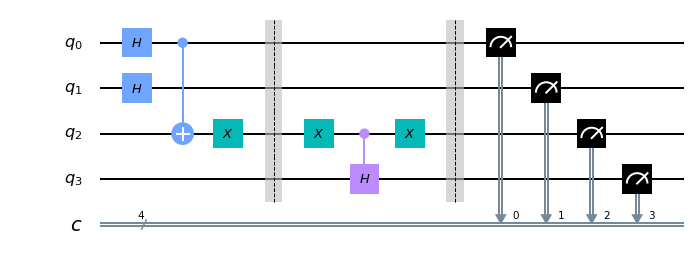

In [33]:
circ.draw("mpl")

Here we will use the classic simulator of Qiskit.

In [34]:
nruns = 2048
backend_sim = Aer.get_backend('qasm_simulator')
job_sim = execute(circ, backend_sim, shots=nruns)
result_sim = job_sim.result()

In [35]:
counts = result_sim.get_counts(circ)

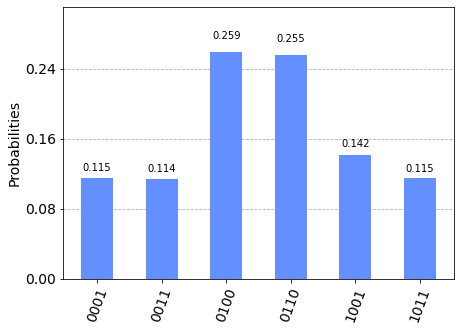

In [36]:
plot_histogram(counts)

Here's a simple filter to get the right answers.

In [37]:
dict(filter(lambda x: x[1]/nruns >= 0.2,counts.items()))

{'0110': 523, '0100': 530}